In [1]:
import numpy as np
import os
from PIL import Image
import helper
import json
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
# width size
w = 512

# height size
h = 512

# number of channels
c = 3


imSize = w * h * c
noImage = 750

In [3]:
print(f"------------------------PCA via covariance matrix-------------------------------")
# read X from folder
X = np.zeros((w * h * c, noImage))

source_train_normal = "./../../../datasets/rosacea-detection/train/normal"
source_train_rosacea = "./../../../datasets/rosacea-detection/train/rosacea"

print("Loading normal faces to X ...")
for i, filename in zip(range(500), os.listdir(source_train_normal)):
    filepath = os.path.join(source_train_normal, filename)
    img = Image.open(filepath)
    X[:, i] = (np.array(img) / 255.0).flatten().copy()
print(f"normal faces loaded.")

print("Loading rosacea faces to X ...")
for i, filename in zip(range(500, 750, 1), os.listdir(source_train_rosacea)):
    filepath = os.path.join(source_train_rosacea, filename)
    img = Image.open(filepath)
    X[:, i] = (np.array(img) / 255.0).flatten().copy()
print(f"rosacea faces loaded.")

------------------------PCA via covariance matrix-------------------------------
Loading normal faces to X ...
normal faces loaded.
Loading rosacea faces to X ...
rosacea faces loaded.


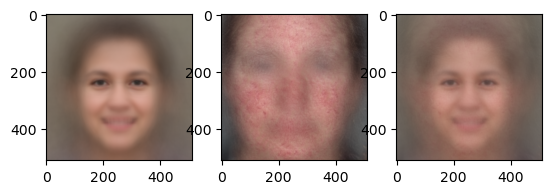

In [4]:
# Mean Vector
meanNormal = np.mean(X[:,:500], 1)
meanRosacea = np.mean(X[:, 500:], 1)
meanFace = np.mean(X, 1)

fig, axs = plt.subplots(1,3)
axs[0].imshow(np.reshape(meanNormal, (w, h, c)))
axs[1].imshow(np.reshape(meanRosacea, (w, h, c)))
axs[2].imshow(np.reshape(meanFace, (w, h, c)))

In [5]:
# center data matrix
for i in range(noImage):
    X[:, i] = X[:, i] - meanFace

In [6]:
# find out the rank of the data matrix
print(f"The rank of the data matrix is: {np.linalg.matrix_rank(X)}")

The rank of the data matrix is: 749


In [7]:
# step 1 : eig, mxm
eVals, eVects = np.linalg.eig(np.matmul(np.transpose(X), X) / (noImage - 1))

In [8]:
# eigenvectors are orthogonal and normalized 

print(np.shape(eVals))
print(np.shape(eVects))
print(np.sum(np.identity(750)-np.matmul(eVects, np.transpose(eVects))))

# eigenvalues are not sorted
is_sorted = lambda a: np.all(a[:-1] >= a[1:])
print(is_sorted(eVals))

# sqrt will have error on one of the eigenvalues which is close to 0
idx = np.where(eVals <= 0)
print(eVals[idx[0][:]])

(750,)
(750, 750)
1.4699551475263204e-13
False
[-8.33353839e-14]


In [9]:
# Sort the eigenvalues and its corresponding eigenvectors

idx = eVals.argsort()[::-1]   
eVals = eVals[idx]
eVects = eVects[:,idx]

In [10]:
# make the last eigenvlues to be positive 0+ for the purpose of using sqrt
# make the corresponding eigenvector 
eVals[-1] = -eVals[-1]
eVects[:, -1] = -eVects[:, -1]
print(np.all(eVals > 0))

True


In [11]:
is_sorted(eVals)

True

In [12]:
# Step 2 : eig. nxn;
# Eigenvectors or Eigenfaces
Evect = np.matmul(X, eVects)

In [13]:
print(np.linalg.norm(Evect[:,0]))

2356.6274350666317


In [14]:
# Step 3 : normalization
Evect_norm = np.zeros((imSize, noImage))
for i in range(noImage):
    Evect_norm[:, i] = Evect[:, i] / np.linalg.norm(Evect[:,i])

In [15]:
print(np.linalg.norm(Evect_norm[:,0]))

0.9999999999999998


In [16]:
np.shape(Evect_norm)

(786432, 750)

In [17]:
# get rid of the last eigenvalue which is 0 and the corresponding eigenvector
eVals_ = eVals [:-1]
Evect_norm_ = Evect_norm[:, :-1]

In [18]:
print(np.shape(eVals_))
print(np.shape(Evect_norm_))

(749,)
(786432, 749)


In [19]:
W = np.matmul(Evect_norm_, np.diag(1 / (eVals_ ** (0.5))))

In [20]:
np.shape(W)

(786432, 749)

In [21]:
# a scalar is returned
def whitened_cosine_distance(u, v):
    W_tu = np.matmul(u,W)
    W_tv = np.matmul(v,W)
    return  (np.linalg.norm(W_tu) * np.linalg.norm(W_tv)) / np.dot(W_tu, W_tv)

In [22]:
Y_train = np.zeros(750)
Y_train[500:] = 1

In [28]:
val_normal_path = "./../../../datasets/rosacea-detection/val/normal"
val_rosacea_path = "./../../../datasets/rosacea-detection/val/rosacea"
test_normal_path = "./../../../datasets/rosacea-detection/test/normal"
test_rosacea_path = "./../../../datasets/rosacea-detection/test/rosacea"

for k in range(1,31,2):
    knn = KNeighborsClassifier(n_neighbors = k, metric = whitened_cosine_distance)
    knn.fit(np.transpose(X), Y_train)
    
    TP_v, TN_v, FP_v, FN_v = 0, 0, 0, 0
    TP_t, TN_t, FP_t, FN_t = 0, 0, 0, 0
    
    print(f"k is {k}")
    # Validation
    print("--------------------Validating-----------------------")
    count = 1
    for filename in os.listdir(val_normal_path):
        file_path = os.path.join(val_normal_path, filename)
        sample = ((np.array(Image.open(file_path)) / 255.0).flatten() - meanFace).reshape(1, -1)
        if knn.predict(sample) == 0:
            TN_v += 1
            print(f"{count}th sample in normal is validated to be True Negative, TN_v:{TN_v}, FP_v:{FP_v}")
        else:
            FP_v += 1
            print(f"{count}th sample in normal is validated to be False Positive, TN_v:{TN_v}, FP_v:{FP_v}")
        count += 1
        
    count = 1
    for filename in os.listdir(val_rosacea_path):
        file_path = os.path.join(val_rosacea_path, filename)
        sample = ((np.array(Image.open(file_path)) / 255.0).flatten() - meanFace).reshape(1, -1)
        if knn.predict(sample) == 0:
            FN_v += 1
            print(f"{count}th sample in rosacea is validated to be False Negative, FN_v:{FN_v}, TP_v:{TP_v}")
        else:
            TP_v += 1
            print(f"{count}th sample in rosacea is validated to be True Positive, FN_v:{FN_v}, TP_v:{TP_v}")
        count += 1
    
    
    # Test
    print("--------------------Testing--------------------------")
    count = 1
    for filename in os.listdir(test_normal_path):
        file_path = os.path.join(test_normal_path, filename)
        sample = ((np.array(Image.open(file_path)) / 255.0).flatten() - meanFace).reshape(1, -1)
        if knn.predict(sample) == 0:
            TN_t += 1
            print(f"{count}th sample in normal is tested to be True Negative, TN_t:{TN_t}, FP_t:{FP_t}")
        else:
            FP_t += 1
            print(f"{count}th sample in normal is tested to be False Positive, TN_t:{TN_t}, FP_t:{FP_t}")
        count += 1
        
    count = 1
    for filename in os.listdir(test_rosacea_path):
        file_path = os.path.join(test_rosacea_path, filename)
        sample = ((np.array(Image.open(file_path)) / 255.0).flatten() - meanFace).reshape(1, -1)
        if knn.predict(sample) == 0:
            FN_t += 1
            print(f"{count}th sample in rosacea is tested to be False Negative, FN_t:{FN_t}, TP_t:{TP_t}")
        else:
            TP_t += 1
            print(f"{count}th sample in rosacea is tested to be True Positive, FN_t:{FN_t}, TP_t:{TP_t}")
        count += 1   
        
        
    # Output result
    accuracy_v, precision_v, recall_v, F1_v = helper.get_performance_metrics(
        TP_v, TN_v, FP_v, FN_v)
    
    accuracy_t, precision_t, recall_t, F1_t = helper.get_performance_metrics(
        TP_t, TN_t, FP_t, FN_t)

    result = {
        "unequal" : 1,
        "n_neighbors" :k,

        "TN_v" : TN_v,
        "TP_v" : TP_v,
        "FP_v" : FP_v,
        "FN_v" : FN_v,
        "accuracy_v" : accuracy_v,
        "precision_v" : precision_v,
        "recall_v" : recall_v,
        "F1_v" : F1_v,

        "TN_t" : TN_t,
        "TP_t" : TP_t,
        "FP_t" : FP_t,
        "FN_t" : FN_t,
        "accuracy_t" : accuracy_t,
        "precision_t" : precision_t,
        "recall_t" : recall_t,
        "F1_t" : F1_t
    }

    json_object = json.dumps(result, indent = 4)

    # writing to file
    json_name = f"knn-metric-whitened-cosine-n_neighbors={k}.json"
    json_path = os.path.join("./../results/knn-whitened-cosine/",json_name)
    with open(json_path,'w') as outfile:
        outfile.write(json_object)

k is 1
--------------------Validating-----------------------
1th sample in normal is validated to be True Negative, TN_v:1, FP_v:0
2th sample in normal is validated to be True Negative, TN_v:2, FP_v:0
3th sample in normal is validated to be True Negative, TN_v:3, FP_v:0
4th sample in normal is validated to be False Positive, TN_v:3, FP_v:1
5th sample in normal is validated to be False Positive, TN_v:3, FP_v:2
6th sample in normal is validated to be False Positive, TN_v:3, FP_v:3
7th sample in normal is validated to be True Negative, TN_v:4, FP_v:3
8th sample in normal is validated to be False Positive, TN_v:4, FP_v:4
9th sample in normal is validated to be True Negative, TN_v:5, FP_v:4
10th sample in normal is validated to be False Positive, TN_v:5, FP_v:5
11th sample in normal is validated to be True Negative, TN_v:6, FP_v:5
12th sample in normal is validated to be True Negative, TN_v:7, FP_v:5
13th sample in normal is validated to be True Negative, TN_v:8, FP_v:5
14th sample in norma

KeyboardInterrupt: 